In [120]:
import pandas as pd
import numpy as np
from copy import copy
from scipy.special import factorial
from itertools import permutations
import matplotlib.pyplot as plt
import random
import math

In [352]:
class StockCuttingOpt():
    
    def __init__(self, cuts, stock_size, blade_width = 0, cost = None):
        
        '''
            attributes:
                cust (list)                      : floats giving the length of each cut needed
                stock_size (float)               : length of stock sold
                blade_width (float, default = 0) : this adds the waste of the blade 
                                                   width to each cut. I little simplified 
                                                   bc the first cut doesn't need a blade width 
                                                   added, but code adds blade width to all cuts
                cost (float, default = None)     : cost of stock, used if expense is to be measured
                                                   in cost rather than waste
        
        '''
        
        self.cuts = cuts
        
        # sort cuts in descending order
        self.cuts = list(np.sort(self.cuts)[::-1])
        
        # add blade width to each cut -- this is a slight simplification bc n - 1 cuts on a stock need
        # blade width adjustments, this process assumes n cuts need blade width
        self.cuts = [x + blade_width for x in self.cuts]
        
        self.stock_size = stock_size
        self.cost = cost
        
        # check to make sure all cuts are no longer than the stock
        cuts_greater_than_stock = sum([True if x > self.stock_size else False for x in self.cuts])
        self.cut_too_long = True if cuts_greater_than_stock > 0 else False
        
        # advise user if any cuts are longer than the stock piece
        if self.cut_too_long:
            
            print('at least one cut is longer than the stock')
        
        return
    
    def _create_cut_plan(self, solution):
        
        '''
            Takes a solution in the form a list, and creates list of lists where each list element
            in the parent list is the cuts to be made on an individual piece of stock
            
            input:
                solution (list) : floats representing the order to make cuts in
                
            output:
                cut_plan (list of lists) : list of lists where each element list 
                                           has the cuts to be made on a piece of stock
                                           e.g. [[3,2,1], [3,1,1]] is a cut plan where
                                           the first piece of stock is cut into 3, 2, 1
                                           lengths and the second piece is cut into 3, 1, 1
                                           lengths
        
        '''
        
        # set up cumulative variables before loop
        cut_plan = []
        curr_stock_cuts = []
        temp_cut_length = 0
        
        # run through each cut
        for cut in solution:
            
            # if current cut is too big for what remains of the stock
            # update cumulative variables and move onto next piece
            if temp_cut_length + cut > self.stock_size:
                
                # reset cut length
                temp_cut_length = cut
                
                # save stock cut plan
                cut_plan.append(curr_stock_cuts)
                
                # reset cuts for next piece of stock
                curr_stock_cuts = [cut]                
            
            else:
                # add the cut length
                temp_cut_length += cut
                
                # add the cut to the cut plan
                curr_stock_cuts.append(cut)
        
        return cut_plan
    
       
    def _total_cost(self, solution, cost_type = 'waste'):
        
        '''
            Calculates expense of a specific solution.  Can calculate total waste, or total material expense
            
            inputs:
                solution (list) : list of floats depicting a cut solution
                cost_type (str, default = 'waste') : depicts what kind of cost to calculate
                                                     'waste' calculates total cutoff that is wasted
                                                     anything else defaults to calculating material
                                                     expense.
            
            output:
                if cost_type = 'waste' returns 'cut_off_waste' (float) which is the total amount of material
                wasted, else it returns 'total_expense' (float) whichs is the total material cost
        '''
        
        # set cumulative variables to 0 before the loops
        temp_cut_length = 0
        cut_off_waste = 0
        purchases = 0
        
        # loop through all cuts
        for cut in solution:
            
            if temp_cut_length + cut > self.stock_size:

                # calculate cutoff waste
                cut_off_waste += self.stock_size - temp_cut_length
                
                # update number of stock peices purchased
                purchases += 1
                
                # reset cut length
                temp_cut_length = cut

            
            else:
                temp_cut_length += cut
        
        
        # add in last cut waste -- it is not captured in the loop
        cut_off_waste += self.stock_size - temp_cut_length
        
        
        # calculate the expense of stock purchased
        total_expense = purchases * self.cost
        
        # return cost metric
        if cost_type == 'waste':
            return cut_off_waste
        elif cost_type == 'expense':
            return total_expense
        else:
            print('please provide a cost_type that is supported by _total_cost method')
            return   
        
    
    def _exhaustive_search(self, expense_hist = False, waste_type = 'expense'):
        
        '''
            Performs an exhaustive search of solution space by going through all potential cut plans
            
            inputs:
                expense_hist (bool, default = False)  : if true, prints a histogram of all cost values
                waste_type (str, default : 'expense') : indicates what kind of cost to calculate
                                                        'expense' calculates material expense
                                                         anything else calcualtes cutoff waste
            output:
                winning_cut_plan (list) : order of optimal cuts
                lowest_cost (float)     : cost of optimal cut plan
        
        '''
        
        # if more than 10mm possible solutions, don't execute search
        if factorial(len(self.cuts)) > 10000000:
            print('exhaustive search would analyze {} scenarios, this is too large'.format(factorial(len(self.cuts))))
        
            return
        
        else:
            
            # set up cumulative variables before loops
            lowest_cost = np.inf
            winning_cut_plan = []
            expense_list = []
            
            # loop through all possible solutions
            for potential_cut_plan in permutations(self.cuts):
                
                # calculate cost of each solution and append to list
                curr_cost = self._total_cost(potential_cut_plan, waste_type)
                expense_list.append(curr_cost)
                
                # asses if the current cost is the best seen so far
                if curr_cost < lowest_cost:
                    
                    lowest_cost = curr_cost
                    winning_cut_plan = potential_cut_plan
            
            # create histogram if requested
            if expense_hist:
                plt.hist(expense_list)
            
            return winning_cut_plan, lowest_cost
        
    
    def _greedy_search(self, waste_type = 'expense'):
        
        '''
            Executes a greedy solution to the stock cutting problem. Puts the largest
            cut that can fit on current remaining piece of stock iteratively.
            
            input
                waste_type (str, default = 'expense') : identifies type of waste to return,
                                                        'expense' returns material cost
                                                        anything else returns cutoff waste.
            outputs
                cut_plan (list)    : order of cuts to be made in greedy solution
                total_cost (float) : total cost of the greedy solution's cut plan
        
        '''
        
        # if a cut is longer than the stock print warning and return none
        if self.cut_too_long:
            print('at least one cut is longer than the stock, ending function call')
            return None
        
        # set cumulative variables before loop
        cut_plan = []
        self.greedy_purchase = 0
        
        cut_off = self.stock_size
        cuts_copy = copy(self.cuts)
        
        # keep on looping until all cuts have been assigned an order
        # and there are no more left in cuts_copy
        while len(cuts_copy) > 0:
            
            # go through each cut and see if it fits,
            # remember the cuts list was already ordered in the 
            # __init__ method, otherwise this loop wouldn't find
            # the greedy solution
            for cut_size in cuts_copy:
            
                if cut_size < cut_off:

                    # add cut to plan
                    cut_plan.append(cut_size)
                    # update the leftover amount
                    cut_off -= cut_size
                    
                    # remove assigned cut from list of unassigned cuts
                    cuts_copy.remove(cut_size)

            # restart cut off size to be the stock
            cut_off = self.stock_size
        
        # save cut plan as an attribute
        self.greedy_cut_plan = cut_plan
        
        # calculate total cost
        total_cost = self._total_cost(cut_plan, waste_type)
        
        return cut_plan, total_cost
    
    def _random_search(self, iterations, waste_type = 'expense'):
        
        '''
            randomly searches solution space multiple times and gives best solution found
            
            inputs
                iterations (int) : number of random searches to perform
                waste_type (str, default = 'expense') : identifies type of waste to return,
                                                        'expense' returns material cost
                                                        anything else returns cutoff waste
                                                        
            outputs
                cut_plan (list)    : order of cuts to be made in greedy solution
                total_cost (float) : total cost of the greedy solution's cut plan
        '''
        
        # make a list to keep track of what has already been tried to 
        # prevent using an iteration on a cut plan that has been tried already
        already_tried = []
        lowest_cost = np.inf
        temp_cut_plan = copy(self.cuts)
        
        # check iterations number of solutions
        for i in range(0, iterations + 1):
            
            # randomly order list to make a cut plan
            random.shuffle(temp_cut_plan)
            
            # check if cut plan has already been tried
            while temp_cut_plan in already_tried:
                random.shuffle(temp_cut_plan)
            
            # update the list of cut plans that have been tried
            already_tried.append(copy(temp_cut_plan))
            
            # update cost
            temp_cost = self._total_cost(temp_cut_plan, waste_type)
            
            # if the current solution is better than any other found
            # save it as the best solution
            if temp_cost < lowest_cost:
                
                best_cut_plan = temp_cut_plan
                lowest_cost = temp_cost
                
        return best_cut_plan, lowest_cost
        

Text(0.5, 1.0, 'Number of Possible Cut Plans by Number of Cuts')

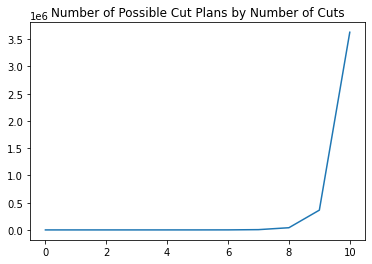

In [129]:
# calculate factorials so we know when to stop
factorial_list = []
for i in range(0,11):
    factorial_list.append(math.factorial(i))

plt.plot(range(0,11), factorial_list)
plt.title('Number of Possible Cut Plans by Number of Cuts')

In [303]:
# difference between greedy and global as number of cuts increase
stock_size = 1.1
iterations = 250

avg_diff = {}
avg_greedy_costs = {}
avg_exhaustive_costs = {}


for num_cuts in range(2, 10):
    
    # reset cost lists for this iteration of number of cuts
    greedy_costs = []
    exhaustive_costs = []
    
    for x in range(0, iterations + 1):
        
        temp_cut_list = np.random.rand(num_cuts)
        
        cutting = StockCuttingOpt(temp_cut_list, stock_size)
        
        exhaustive_solution = cutting._exhaustive_search(waste_type = 'waste')
        exhaustive_cost = exhaustive_solution[1]
        exhaustive_costs.append(exhaustive_cost)
        
        greedy_solution = cutting._greedy_search(waste_type = 'waste')
        greedy_cost = greedy_solution[1]
        greedy_costs.append(greedy_cost)

        cost_difference.append(greedy_cost - exhaustive_cost)
    
    
    avg_greedy_costs[num_cuts] = np.mean(greedy_costs)
    avg_exhaustive_costs[num_cuts] = np.mean(exhaustive_costs)
    avg_diff[num_cuts] = np.mean(cost_difference)


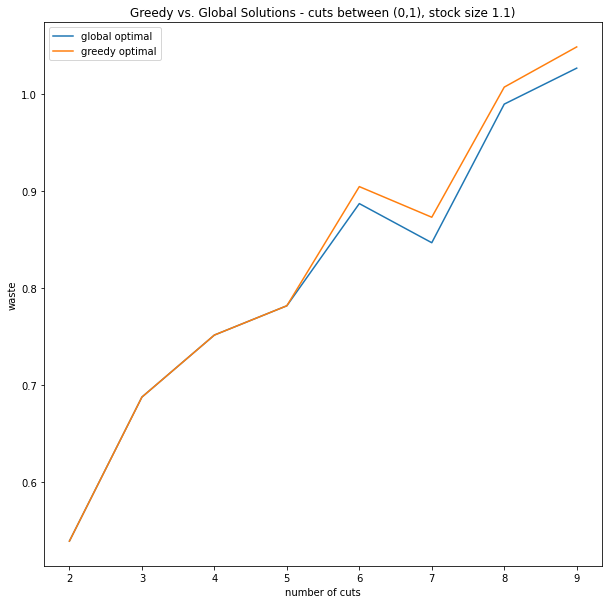

In [305]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(avg_exhaustive_costs.keys(), avg_exhaustive_costs.values(), label = 'global optimal')
plt.plot(avg_greedy_costs.keys(), avg_greedy_costs.values(), label = 'greedy optimal')
plt.legend()
plt.title('Greedy vs. Global Solutions - cuts between (0,1), stock size 1.1)')
plt.xlabel('number of cuts')
plt.ylabel('waste')
plt.show()

In [321]:
# difference between greedy and global as number of cuts increase
stock_size = 1.1
iterations = 25

# create empty cumulative variables before loop
avg_diff = {}
avg_greedy_costs = {}
avg_random_search_costs = {}

# try a lot of different cut list sizes
for num_cuts in range(5, 200, 25):
    
    # reset cost lists for this iteration of number of cuts
    greedy_costs = []
    random_search_costs = []
    
    # create multiple random cut lists of a specific size
    for x in range(0, iterations + 1):
        
        # set up number of random searches
        if math.factorial(num_cuts) < 1000:
            random_searches = 10
        else:
            random_searches = 500
        
        temp_cut_list = np.random.rand(num_cuts)
        
        cutting = StockCuttingOpt(temp_cut_list, stock_size)
        
        random_search_solution = cutting._random_search(random_searches, waste_type = 'waste')
        random_search_cost = random_search_solution[1]
        random_search_costs.append(random_search_cost)
        
        greedy_solution = cutting._greedy_search(waste_type = 'waste')
        greedy_cost = greedy_solution[1]
        greedy_costs.append(greedy_cost)

        cost_difference.append(greedy_cost - random_search_cost)
    
    
    avg_greedy_costs[num_cuts] = np.mean(greedy_costs)
    avg_random_search_costs[num_cuts] = np.mean(random_search_costs)
    avg_diff[num_cuts] = np.mean(cost_difference)

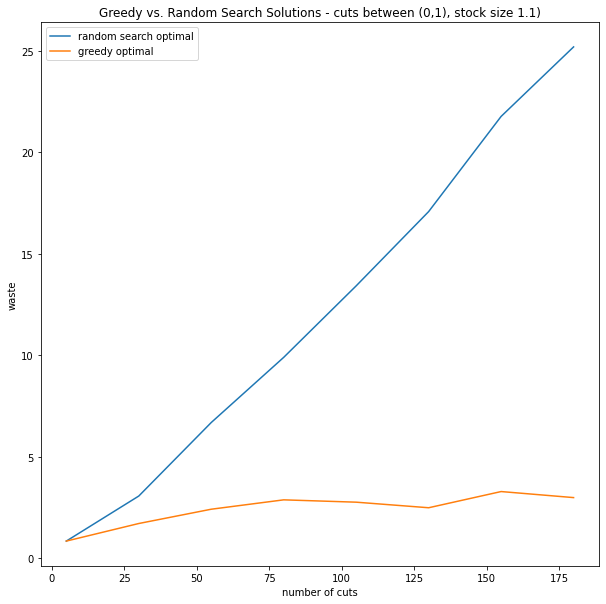

In [322]:
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(avg_random_search_costs.keys(), avg_random_search_costs.values(), label = 'random search optimal')
plt.plot(avg_greedy_costs.keys(), avg_greedy_costs.values(), label = 'greedy optimal')
plt.legend()
plt.title('Greedy vs. Random Search Solutions - cuts between (0,1), stock size 1.1)')
plt.xlabel('number of cuts')
plt.ylabel('waste')
plt.show()

In [354]:
# actual problem that I need to solve with blade width consideration
# 24' pieces
cuts = [48, 48, 48, 48, 48, 52, 52, 52, 52, 18, 56, 56, 2, 2, 2, 2]
stock_size = 288
cost = 20.8
blade_width = 1/8

steel_cutting_24 = StockCuttingOpt(cuts, stock_size, blade_width, cost)
greedy_cut_plan_24 = steel_cutting_24._greedy_search(waste_type = 'expense')
print(steel_cutting_24._create_cut_plan(greedy_cut_plan_24[0]))
print('total cost = ', greedy_cut_plan_24[1])

[[56.125, 52.125, 52.125, 48.125, 48.125, 18.125, 2.125, 2.125], [56.125, 52.125, 48.125, 2.125, 52.125, 48.125]]
total cost =  41.6


In [355]:
# actual problem that I need to solve with blade width consideration
# 20' pieces
cuts = [48, 48, 48, 48, 48, 52, 52, 52, 52, 18, 56, 56, 2, 2, 2, 2]
stock_size = 240
cost = 17.30
blade_width = 1/8

steel_cutting_20 = StockCuttingOpt(cuts, stock_size, blade_width, cost)
greedy_cut_plan_20 = steel_cutting_20._greedy_search(waste_type = 'expense')
print(steel_cutting_20._create_cut_plan(greedy_cut_plan_20[0]))
print('total cost = ', greedy_cut_plan_20[1])

[[56.125, 52.125, 52.125, 48.125, 18.125, 2.125, 2.125], [56.125, 52.125, 48.125, 48.125, 2.125]]
total cost =  34.6


In [253]:
# functions outside of classes for article
def total_waste(stock_size, solution):
    
    '''
        Calculates cutoff waste give a specific solution
        
        inputs
        stock_size (float) : the dimension of the stock available for purchase
        solution (list)    : list of floats depicting the order to make the cuts
        
        output
        cut_off_waste (float) : the total cutoff waste of the given solution
    
    '''
    
    # set up variable to keep track of the total lengths of 
    # cuts on current piece of stock
    temp_cut_length = 0
    
    # start with no waste
    cut_off_waste = 0

    for cut in solution:
        
        # if next cut doesn't fit on current stock,
        # calculate and save waste and reset for another piece of stock
        if temp_cut_length + cut > stock_size:

            # calculate cutoff waste
            cut_off_waste += stock_size - temp_cut_length

            # reset cut length
            temp_cut_length = cut

        else:
            # add to cumulative length of cuts on stock
            temp_cut_length += cut


    # add in last cut waste -- it is not captured in the loop
    cut_off_waste += stock_size - temp_cut_length
    
    return cut_off_waste


In [258]:
# functions outside of classes for article
def greedy_search(cuts, stock_size):
    
    '''
        Calculates a greedy optimal solution
        
        inputs:
        cuts (list)        : cuts that need to be made
        stock_size (float) : size of stock available for purchase
        
        outputs:
        cut_plan (list) : sequence of cuts to obtain greedy optimal results
        waste (float)   : amount of material wasted by solution
        
    '''
    
    # empty cut off plan, to be populated
    cut_plan = []
    # start with cutoff size equal to stock size
    cut_off = stock_size
    # copy cuts list to avoid modifying original list
    cuts_copy = copy(cuts)
    
    # sort cuts in desc order
    cuts = list(np.sort(cuts)[::-1])
    
    # continue ordering cuts until
    # all cuts have been ordered
    while len(cuts_copy) > 0:

        for cut_size in cuts_copy:
            
            # if cut size is smaller than remaining stock,
            # assign the cut now
            if cut_size < cut_off:

                # add cut to plan
                cut_plan.append(cut_size)
                
                # update the leftover amount
                cut_off -= cut_size
                
                # remove cut from list of cuts still needing 
                # to be ordered
                cuts_copy.remove(cut_size)
        
        # reset cut_off to be the full stock size
        cut_off = stock_size
    
    # calculate waste using total_waste function
    waste = total_waste(stock_size, cut_plan)

    return cut_plan, waste